# Import

In [1]:
import numpy as np
import healpy as hp
import pandas as pd
import networkx as nx
import geopandas as gpd

from pint import UnitRegistry
from datetime import datetime
from tqdm.auto import tqdm
from itertools import combinations

from pyproj import Geod
from shapely import union_all, intersects, STRtree
from shapely.wkt import loads
from shapely.geometry import LineString
from healpix_geo.nested import healpix_to_lonlat
from healpix_geo.nested import lonlat_to_healpix

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

ureg = UnitRegistry()

In [2]:
def get_points(NSIDE):
    NPIX = hp.nside2npix(NSIDE)
    points = np.array(
        hp.pix2vec(NSIDE, range(NPIX), nest=True)
    ).T

    df = pd.DataFrame(points, columns=('x', 'y', 'z'))

    return df

def get_patches(NSIDE):
    NPIX = hp.nside2npix(NSIDE)

    pixels = np.arange(NPIX)
    patches = np.array(
        [hp.boundaries(NSIDE, i, nest=True).T for i in pixels]
    ).reshape(-1, 3)

    df = pd.DataFrame(patches, columns=('x', 'y', 'z'))

    return df

In [3]:
def great_circle_path(a=None, b=None, n_points=100, iterable=False):
    geod = Geod(ellps='WGS84')

    if iterable:
        (a, b) = a

    points = geod.npts(
        a.x, a.y,
        b.x, b.y,
        n_points,
    )
    line = LineString(points)

    return line

def great_circle_distance(a=None, b=None, iterable=False):
    geod = Geod(ellps='WGS84')

    if iterable:
        (a, b) = a

    distance = geod.inv(
        a.x, a.y,
        b.x, b.y,
    )[2]

    return distance

# Data

## Borders

In [4]:
kaz = gpd.read_file('data/geoBoundaries-KAZ-ADM0_simplified.geojson')
ukr = gpd.read_file('data/geoBoundaries-UKR-ADM1_simplified.geojson')
rus = gpd.read_file('data/geoBoundaries-RUS-ADM1_simplified.geojson')
blr = gpd.read_file('data/geoBoundaries-BLR-ADM1_simplified.geojson')
borders = pd.concat((kaz, ukr, rus, blr)).reset_index(drop=True)
borders = borders.to_crs(epsg=4326)
borders

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Kazakhstan,KAZ,12445969B25401373275960,KAZ,ADM0,"MULTIPOLYGON (((50.3741 44.78639, 50.37386 44...."
1,Kherson Oblast,UA-65,14850775B65901307765467,UKR,ADM1,"POLYGON ((35.23342 45.79173, 35.22632 45.81739..."
2,Volyn Oblast,UA-07,14850775B13681962240800,UKR,ADM1,"POLYGON ((25.11276 50.28727, 25.11147 50.29428..."
3,Rivne Oblast,UA-56,14850775B83802928232754,UKR,ADM1,"POLYGON ((25.11276 50.28727, 25.11291 50.28489..."
4,Zhytomyr Oblast,UA-18,14850775B79197734087513,UKR,ADM1,"POLYGON ((27.19595 50.56224, 27.19661 50.55239..."
...,...,...,...,...,...,...
113,Grodno,BY-HR,45462678B41589714648574,BLR,ADM1,"POLYGON ((26.20946 55.00435, 26.20796 54.99397..."
114,Brest,BY-BR,45462678B29468378769629,BLR,ADM1,"POLYGON ((27.29535 52.39133, 27.27942 52.39491..."
115,Mogilev,BY-MA,45462678B58682879627750,BLR,ADM1,"POLYGON ((31.38846 53.08714, 31.4034 53.09979,..."
116,Minsk,BY-MI,45462678B52111461583443,BLR,ADM1,"POLYGON ((28.49337 52.68476, 28.48035 52.69284..."


## Airports

In [5]:
airports = pd.read_csv('data/airports.csv')
airports = gpd.GeoDataFrame(
    airports.drop(['GeoPointLat', 'GeoPointLong'], axis=1),
    geometry=gpd.points_from_xy(
        *airports[['GeoPointLong', 'GeoPointLat']].values.T
    ), crs='EPSG:4326'
)
airports[airports.ICAO.isin(['KJFK', 'UAAA'])]

,AirportName,IATA,ICAO,TimeZone,City_Name,City_IATA,UTC_Offset_Hours,UTC_Offset_Seconds,Country_CodeA2,Country_CodeA3,Country_Name,geometry
2169,John F Kennedy Intl,JFK,KJFK,America/New_York,"New York, New York",NYC,-4.0,-14400.0,US,USA,United States of America,POINT (-73.77892 40.63975)
5300,Almaty,ALA,UAAA,Asia/Qyzylorda,Almaty,ALA,5.0,18000.0,KZ,KAZ,Kazakhstan,POINT (77.04051 43.35207)


# HEALPix

In [6]:
NSIDE = 16
healpix = get_points(NSIDE)

NPIX = hp.nside2npix(NSIDE)
ipix = np.arange(NPIX)
depth = np.log2(NSIDE).astype(int)

print(NPIX, depth)

3072 4


In [7]:
lon, lat = healpix_to_lonlat(ipix, depth=depth, ellipsoid='WGS84')
lon = (lon + 180) % 360 - 180

In [8]:
borders_restricted = borders.loc[
    borders.shapeGroup.isin(['RUS', 'UKR', 'BLR']),
].reset_index(drop=True)

shape_restricted = union_all(
    borders_restricted.geometry
)

tree = STRtree(borders_restricted.geometry)

In [9]:
start = lonlat_to_healpix(
    airports[airports.ICAO=='UAAA'].geometry.x,
    airports[airports.ICAO=='UAAA'].geometry.y,
    depth,
    ellipsoid='WGS84',
)[0]
end = lonlat_to_healpix(
    airports[airports.ICAO=='KJFK'].geometry.x,
    airports[airports.ICAO=='KJFK'].geometry.y,
    depth,
    ellipsoid='WGS84',
)[0]

In [10]:
gdf = gpd.GeoDataFrame(
    healpix,
    geometry=gpd.points_from_xy(
        lon, lat
    ),
    crs='EPSG:4326',
)
gdf = gdf[~gdf.geometry.intersects(shape_restricted)]
gdf

,x,y,z,geometry
0,0.706493,0.706493,0.041667,POINT (45 2.39873)
1,0.669223,0.738374,0.083333,POINT (47.8125 4.80155)
2,0.738374,0.669223,0.083333,POINT (42.1875 4.80155)
3,0.701561,0.701561,0.125000,POINT (45 7.21266)
4,0.629418,0.766948,0.125000,POINT (50.625 7.21266)
...,...,...,...,...
3067,0.629418,-0.766948,-0.125000,POINT (-50.625 -7.21266)
3068,0.701561,-0.701561,-0.125000,POINT (-45 -7.21266)
3069,0.738374,-0.669223,-0.083333,POINT (-42.1875 -4.80155)
3070,0.669223,-0.738374,-0.083333,POINT (-47.8125 -4.80155)


# Graph

In [164]:
import cupy
import cudf
import cugraph

In [171]:
def remove_edge(df, source, target):
    df = df.drop(
        df[
            (df.source==source) & (df.target==target)
        ].index
    )

    G = cugraph.Graph()
    G.from_cudf_edgelist(
        df,
        destination='target',
        weight='weight',
    )

    return df, G

In [167]:
def get_predecessors(paths, node, route):
    vertices = cupy.asnumpy(paths.loc[paths.vertex==node, 'vertex'].values)
    preds = cupy.asnumpy(paths.loc[paths.vertex==node, 'predecessor'].values)
    route.append(vertices[0])

    if -1 not in preds:
        for pred in preds:
            get_predecessors(paths, pred, route)

In [177]:
df = cudf.from_pandas(
    pd.read_csv('points_graph.csv')
)

G = cugraph.Graph()
G.from_cudf_edgelist(
    df,
    destination='target',
    weight='weight',
)

In [178]:
avoid = True
counter = 0
start_time = datetime.now()

avg_pathfind_time = []
avg_intersect_time = []

while avoid:
    counter += 1
    route = []

    pathfind_start = datetime.now()

    paths = cugraph.sssp(
        G,
        start,
    )
    get_predecessors(paths, end, route)

    avg_pathfind_time.append(datetime.now() - pathfind_start)

    intersect = False

    intersect_start = datetime.now()

    for idx in range(len(route) - 1):
        point_a = route[idx]
        point_b = route[idx+1]

        coord_a = gdf.loc[point_a, 'geometry']
        coord_b = gdf.loc[point_b, 'geometry']

        #great_circle_start = datetime.now()

        path = great_circle_path(
            coord_a,
            coord_b,
            n_points=50,
        )

        #avg_great_circle_time.append(datetime.now() - great_circle_start)

        candidates_idx = tree.query(
            geometry=great_circle_path(
                *gdf.loc[[start, end], 'geometry'].values,
                n_points=50,
            ),
            predicate='intersects',
        )
        candidates = borders_restricted.loc[candidates_idx]

        for idx, candidate in candidates.iterrows():
            intersect = path.intersects(candidate.geometry)

            if intersect:
                avg_intersect_time.append(datetime.now() - intersect_start)
                df, G = remove_edge(df, point_a, point_b)
                break

        if intersect:
            break

    if counter % 250 == 0:
        elapsed = datetime.now() - start_time
        print(f'iterations: {counter}')
        print(f'time elapsed: {elapsed}')
        print(f'avg iteration time: {elapsed / counter}')
        print(f'avg pathfind time: {pd.to_timedelta(avg_pathfind_time).mean().to_pytimedelta()}')
        #print(f'avg great circle time: {pd.to_timedelta(avg_great_circle_time).mean().to_pytimedelta()}')
        print(f'avg intersect time: {pd.to_timedelta(avg_intersect_time).mean().to_pytimedelta()}\n')

    if not intersect:
        avoid = False

end_time = datetime.now()
elapsed = end_time - start_time

print(f'total iterations: {counter}\ntime elapsed: {elapsed}\navg iteration time: {elapsed / counter}')

iterations: 250
time elapsed: 0:01:14.056268
avg iteration time: 0:00:00.296225
avg pathfind time: 0:00:00.055171
avg intersect time: 0:00:00.008115

iterations: 500
time elapsed: 0:02:28.213241
avg iteration time: 0:00:00.296426
avg pathfind time: 0:00:00.055495
avg intersect time: 0:00:00.008096

iterations: 750
time elapsed: 0:03:42.600504
avg iteration time: 0:00:00.296801
avg pathfind time: 0:00:00.055960
avg intersect time: 0:00:00.008092

iterations: 1000
time elapsed: 0:04:56.882719
avg iteration time: 0:00:00.296883
avg pathfind time: 0:00:00.056206
avg intersect time: 0:00:00.008080

iterations: 1250
time elapsed: 0:06:11.367234
avg iteration time: 0:00:00.297094
avg pathfind time: 0:00:00.056446
avg intersect time: 0:00:00.008077

iterations: 1500
time elapsed: 0:07:25.738140
avg iteration time: 0:00:00.297159
avg pathfind time: 0:00:00.056573
avg intersect time: 0:00:00.008073

iterations: 1750
time elapsed: 0:08:40.030771
avg iteration time: 0:00:00.297160
avg pathfind tim

KeyboardInterrupt: 

In [179]:
gdf.loc[route]

,x,y,z,geometry
932,0.226603,-0.747011,0.625000,POINT (-73.125 38.80745)
89,0.181107,0.723019,0.666667,POINT (75.9375 41.93785)


In [66]:
gdf_route = gdf.loc[route].geometry.reset_index()
gdf_route = gdf_route.rename({'index': 'point_id'}, axis=1)
gdf_route.point_id = gdf_route.point_id.astype(str)

gdf_route.loc[gdf_route.point_id==str(start), 'point_id'] = 'UAAA'
gdf_route.loc[gdf_route.point_id=='UAAA', 'geometry'] = airports.loc[airports.ICAO=='UAAA', 'geometry'].values

gdf_route.loc[gdf_route.point_id==str(end), 'point_id'] = 'KJFK'
gdf_route.loc[gdf_route.point_id=='KJFK', 'geometry'] = airports.loc[airports.ICAO=='KJFK', 'geometry'].values

gdf_route

,point_id,geometry
0,UAAA,POINT (77.04051 43.35207)
1,99,POINT (56.25 38.80745)
2,149,POINT (42.1875 41.93785)
3,155,POINT (27 45.12218)
4,KJFK,POINT (-73.77892 40.63975)


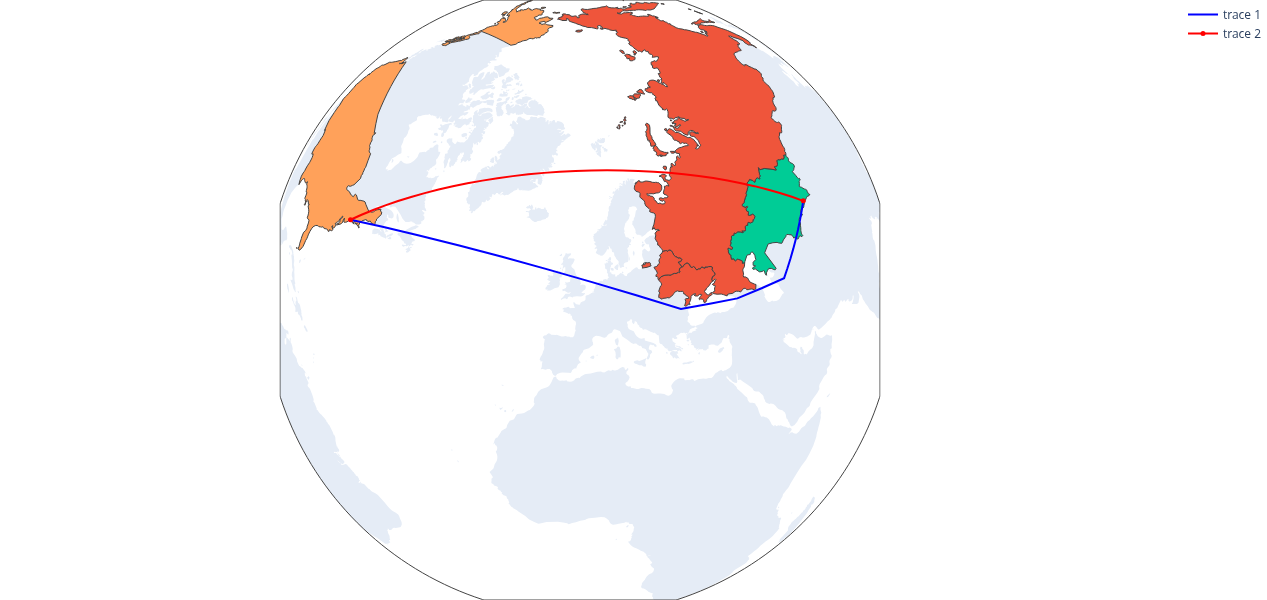

In [67]:
countries = ['KAZ', 'UKR', 'RUS', 'BLR', 'USA']

fig = go.Figure()

trace = go.Choropleth(
    locations=countries,
    z=list(range(len(countries))),
    locationmode='ISO-3',
    colorscale=np.array(px.colors.qualitative.Plotly)[[2, 1, 1, 1, 4]],
    text=countries,
    showscale=False,
)
fig.add_trace(trace)

route_trace = go.Scattergeo(
    lon=gdf_route.geometry.x,
    lat=gdf_route.geometry.y,
    mode='lines',
    marker=dict(size=1, color='blue'),
)
fig.add_trace(route_trace)

start_end = go.Scattergeo(
    lon=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.x,
    lat=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.y,
    mode='lines+markers',
    marker=dict(size=5, color='red'),
)
fig.add_trace(start_end)

fig.update_geos(
    fitbounds='locations',
    visible=False,
    projection_type='orthographic',
)
fig.update_layout(
    autosize=False,
    width=900, height=600,
    margin=dict(l=0, r=0, b=0, t=0),
    geo=dict(
        showframe=True,
        showland=True,
    ),
)
fig.show()

In [37]:
nx.config.backend_priority = ['cugraph']

In [50]:
G.__networkx_cache__.clear()

paths = nx.single_source_dijkstra(
    G, start,
)

In [64]:
points_withtin_range = [
    key
    for key, value
    in paths[0].items()
    if (value * ureg.meter).to(ureg.nautical_mile).magnitude < 7e3
]

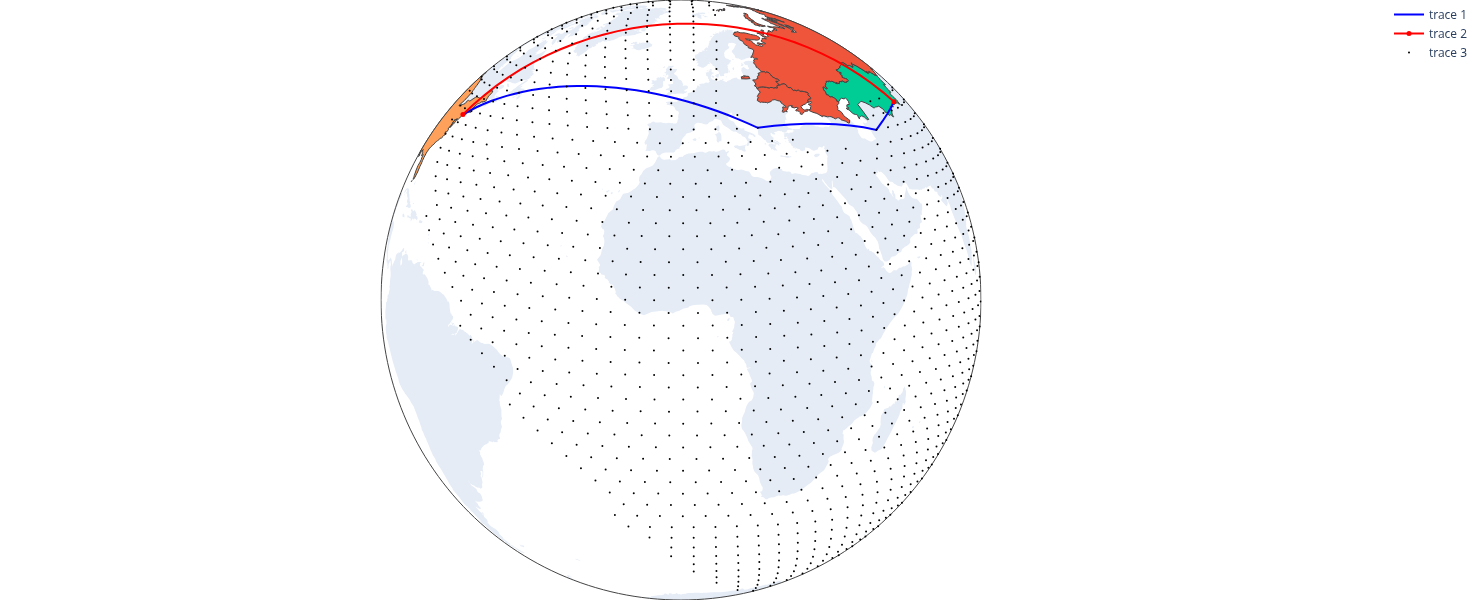

In [115]:
countries = ['KAZ', 'UKR', 'RUS', 'BLR', 'USA']

fig = go.Figure()

trace = go.Choropleth(
    locations=countries,
    z=list(range(len(countries))),
    locationmode='ISO-3',
    colorscale=np.array(px.colors.qualitative.Plotly)[[2, 1, 1, 1, 4]],
    text=countries,
    showscale=False,
)
fig.add_trace(trace)

route_trace = go.Scattergeo(
    lon=gdf_route.geometry.x,
    lat=gdf_route.geometry.y,
    mode='lines',
    marker=dict(size=1, color='blue'),
)
fig.add_trace(route_trace)

start_end = go.Scattergeo(
    lon=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.x,
    lat=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.y,
    mode='lines+markers',
    marker=dict(size=5, color='red'),
)
fig.add_trace(start_end)

points = go.Scattergeo(
    lon=gdf.loc[points_withtin_range].geometry.x,
    lat=gdf.loc[points_withtin_range].geometry.y,
    mode='markers',
    marker=dict(size=2, color='black'),
)
fig.add_trace(points)

fig.update_geos(
    fitbounds='locations',
    visible=False,
    projection_type='orthographic',
)
fig.update_layout(
    autosize=False,
    width=900, height=600,
    margin=dict(l=0, r=0, b=0, t=0),
    geo=dict(
        showframe=True,
        showland=True,
    ),
)
fig.show()

In [138]:
edge_points_mask = np.isin(
    hp.get_all_neighbours(NSIDE, points_withtin_range, nest=True).T,
    points_withtin_range
).sum(axis=1)<7

edge_points = np.array(points_withtin_range)[edge_points_mask]
gdf.loc[edge_points]

,x,y,z,geometry
55,0.533267,0.649787,0.541667,POINT (50.625 32.91413)
60,0.594389,0.594389,0.541667,POINT (45 32.91413)
62,0.601825,0.545462,0.583333,POINT (42.1875 35.80701)
86,0.109366,0.737289,0.666667,POINT (81.5625 41.93785)
87,0.037011,0.706213,0.707031,POINT (87 45.12218)
...,...,...,...,...
372,-0.615593,0.112812,0.779948,POINT (169.61538 51.38099)
375,-0.537405,0.038436,0.842448,POINT (175.90909 57.51586)
365,-0.584034,0.322784,0.744792,POINT (151.07143 48.2687)
364,-0.593093,0.385159,0.707031,POINT (147 45.12218)


In [188]:
edge_points_neighbours = hp.get_all_neighbours(NSIDE, edge_points, nest=True).T

In [215]:
neighbours_drop = edge_points[
    np.unique_counts(
        edge_points_neighbours[
            np.isin(edge_points_neighbours, edge_points)
        ]
    ).counts>2
]

In [ ]:
np.

In [218]:
neighbours_drop

array([427, 628, 808, 810, 905, 907])

In [217]:
{
    point: neighbour_ids[
        np.isin(neighbour_ids, edge_points)
        & ~np.isin(neighbour_ids, neighbours_drop)
    ]
    for point, neighbour_ids
    in zip(edge_points, edge_points_neighbours)
}

{np.int64(55): array([60, 98]),
 np.int64(60): array([62, 55]),
 np.int64(62): array([145,  60]),
 np.int64(86): array([89, 87]),
 np.int64(87): array([86]),
 np.int64(89): array([90, 86]),
 np.int64(90): array([112,  89]),
 np.int64(98): array([55, 99]),
 np.int64(99): array([ 98, 102]),
 np.int64(102): array([ 99, 103]),
 np.int64(103): array([102, 112]),
 np.int64(112): array([103,  90]),
 np.int64(143): array([165, 152]),
 np.int64(145): array([146,  62]),
 np.int64(146): array([152, 145]),
 np.int64(152): array([143, 146]),
 np.int64(165): array([167, 143]),
 np.int64(167): array([184, 165]),
 np.int64(184): array([185, 167]),
 np.int64(185): array([184, 188]),
 np.int64(317): array([318, 360]),
 np.int64(318): array([404, 317]),
 np.int64(360): array([317, 361]),
 np.int64(404): array([406, 318]),
 np.int64(406): array([409, 412, 404]),
 np.int64(409): array([410, 412, 406]),
 np.int64(410): array([421, 409]),
 np.int64(412): array([409, 406]),
 np.int64(421): array([422, 423, 41

In [204]:
np.unique_counts(edge_points_neighbours)

UniqueCountsResult(values=array([  51,   52,   53,   54,   55,   57,   58,   59,   60,   61,   62,
         63,   77,   79,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   96,   97,   98,   99,  100,
        101,  102,  103,  104,  105,  108,  109,  112,  113,  114,  115,
        120,  133,  135,  140,  141,  142,  143,  144,  145,  146,  147,
        148,  149,  150,  152,  153,  154,  155,  164,  165,  166,  167,
        172,  173,  175,  176,  178,  179,  182,  183,  184,  185,  186,
        187,  188,  189,  190,  191,  226,  227,  230,  232,  233,  234,
        235,  236,  237,  238,  239,  242,  243,  246,  247,  248,  249,
        250,  251,  252,  253,  254,  255,  310,  311,  313,  315,  316,
        317,  318,  319,  335,  346,  347,  350,  351,  354,  355,  356,
        357,  358,  359,  360,  361,  362,  363,  364,  365,  366,  367,
        368,  369,  370,  371,  372,  373,  374,  375,  376,  378,  380,
        381,  397,  398, 

In [201]:
{
    point: neighbour_ids[
        np.isin(neighbour_ids, edge_points)
    ]
    for point, neighbour_ids
    in zip(edge_points, edge_points_neighbours)
}

{np.int64(55): array([60, 98]),
 np.int64(60): array([62, 55]),
 np.int64(62): array([145,  60]),
 np.int64(86): array([89, 87]),
 np.int64(87): array([ 86, 427]),
 np.int64(89): array([90, 86]),
 np.int64(90): array([112,  89]),
 np.int64(98): array([55, 99]),
 np.int64(99): array([ 98, 102]),
 np.int64(102): array([ 99, 103]),
 np.int64(103): array([102, 112]),
 np.int64(112): array([103,  90]),
 np.int64(143): array([165, 152]),
 np.int64(145): array([146,  62]),
 np.int64(146): array([152, 145]),
 np.int64(152): array([143, 146]),
 np.int64(165): array([167, 143]),
 np.int64(167): array([184, 165]),
 np.int64(184): array([185, 167]),
 np.int64(185): array([184, 188]),
 np.int64(317): array([318, 360]),
 np.int64(318): array([404, 317]),
 np.int64(360): array([317, 361]),
 np.int64(404): array([406, 318]),
 np.int64(406): array([409, 412, 404]),
 np.int64(409): array([410, 412, 406]),
 np.int64(410): array([421, 409]),
 np.int64(412): array([409, 406]),
 np.int64(421): array([422, 4

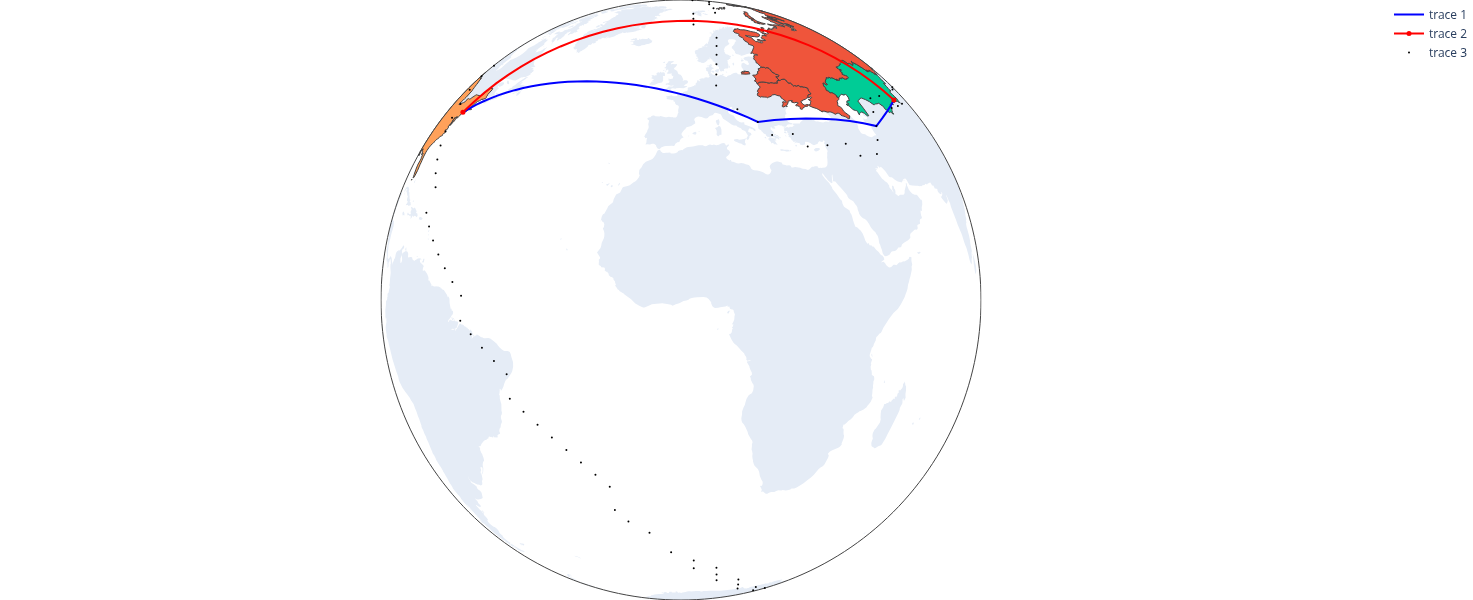

In [139]:
countries = ['KAZ', 'UKR', 'RUS', 'BLR', 'USA']

fig = go.Figure()

trace = go.Choropleth(
    locations=countries,
    z=list(range(len(countries))),
    locationmode='ISO-3',
    colorscale=np.array(px.colors.qualitative.Plotly)[[2, 1, 1, 1, 4]],
    text=countries,
    showscale=False,
)
fig.add_trace(trace)

route_trace = go.Scattergeo(
    lon=gdf_route.geometry.x,
    lat=gdf_route.geometry.y,
    mode='lines',
    marker=dict(size=1, color='blue'),
)
fig.add_trace(route_trace)

start_end = go.Scattergeo(
    lon=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.x,
    lat=airports[airports.ICAO.isin(['KJFK', 'UAAA'])].geometry.y,
    mode='lines+markers',
    marker=dict(size=5, color='red'),
)
fig.add_trace(start_end)

points = go.Scattergeo(
    lon=gdf.loc[edge_points].geometry.x,
    lat=gdf.loc[edge_points].geometry.y,
    mode='markers',
    marker=dict(size=2, color='black'),
)
fig.add_trace(points)

fig.update_geos(
    fitbounds='locations',
    visible=False,
    projection_type='orthographic',
)
fig.update_layout(
    autosize=False,
    width=900, height=600,
    margin=dict(l=0, r=0, b=0, t=0),
    geo=dict(
        showframe=True,
        showland=True,
    ),
)
fig.show()

In [ ]:
route_segments = pd.DataFrame([
    {
        'segment': f'{window.point_id.values[0]} - {window.point_id.values[1]}',
        'distance_m': great_circle_distance(*window.geometry.values),
        'distance_nml': (
            great_circle_distance(*window.geometry.values) * ureg.meter
        ).to(ureg.nautical_mile).magnitude,
    }
    for window in gdf_route.rolling(2)
    if len(window) == 2
])
route_segments

In [ ]:
print(
    f'direct UAAA-KJFK: {(
        great_circle_distance(
            *gdf_route[
                gdf_route.point_id.isin(['UAAA', 'KJFK'])
            ].geometry.values
        ) * ureg.meter
    ).to(ureg.nautical_mile).magnitude:.2f} nautical miles'
)
print(f'segmented UAAA-KJFK: {route_segments.distance_nml.sum():.2f} nautical miles')